SIR model

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import math

In [16]:
def fun(p,x): 
    k,b = p
    return k*x+b

def error(p,x,y):
    return fun(p,x)-y

def lesq(data,country):
    x = data['index']
    y = data[country]
    p0 = np.array([1,3])
    para = leastsq(error,p0,args=(x,y))
    k,b = para[0]
    return k,b


def predict(name,country,n):
    data = pd.read_csv(name,delimiter=',')
    data = data.iloc[[n,n+1,n+2,n+3,n+4,n+5]]
    w, b = lesq(data,country)
    x = n + 4
    y_predict = w * (x + 1) + b
    try:
        int(y_predict)
    except:
        y_predict = 0
    if y_predict <= 0:
        y_predict = 0

    return int(y_predict)

def ave_relative_loss(x,y):
    loss = 0
    norm = 0
    for i in range(len(y)):
        a = x.iloc[i]
        b = y[i]
        norm += b**2
        if a == b:
            continue
        else:
            loss += abs(a-b)**2
    
    return math.sqrt(loss/norm)


In [17]:
dic={}
dic['China'] = 241200
dic['US'] = 9320000
dic['United Kingdom'] = 6708100
l_x = [i for i in range(358)]
l_name = ['Number of Confirmed', 'Number of Dead', 'Number of Recovered', 'Number of Susceptible']
l_name1 = ['Number of Confirmed', 'Number of Dead', 'Number of Recovered', 'Real Number of Susceptible', 'Real Number of Confirmed', 'Real Number of Dead', 'Real Number of Recovered']
plt.rcParams['figure.figsize'] = (20.0, 8.0)

def main(fc, fr, fd,l,j1 = False, j2 = False):
    for item in l:
        lc = []
        ld = []
        lr = []
        ls = [] 
        datac = pd.read_csv(fc)
        datad = pd.read_csv(fd)
        datar = pd.read_csv(fr)
        for i in range(5):
            lc.append(datac.loc[i, item])
            ld.append(datad.loc[i, item])
            lr.append(datar.loc[i, item])
            ls.append(dic[item] - datac.loc[i, item]- datad.loc[i, item] - datar.loc[i, item])

        for i in range(358-5):
            predict_confirmed = predict(fc,item,i)
            predict_dead = predict(fd,item,i)
            predict_recovered = predict(fr,item,i)
            predict_susceptible = dic[item] - predict_confirmed - predict_dead - predict_recovered
            lc.append(predict_confirmed)
            ld.append(predict_dead)
            lr.append(predict_recovered)
            ls.append(predict_susceptible)
        plt.plot(l_x,lc)
        plt.plot(l_x,ld)
        plt.plot(l_x,lr)
        plt.plot(l_x,ls)

        if j1:
            plt.plot(l_x,datac[item])
            plt.plot(l_x,datad[item])
            plt.plot(l_x,datar[item])
            plt.legend(l_name1,loc = 'best')
        else:
            plt.legend(l_name,loc = 'best')
            plt.show()
        
        if j2:
            loss_c = ave_relative_loss(datad[item],lc)
            loss_d = ave_relative_loss(datad[item],ld)
            loss_r = ave_relative_loss(datad[item],lr)
            print(loss_c,loss_d,loss_r)





0.9498629653488747 0.009561389074432375 0.9447336409018157


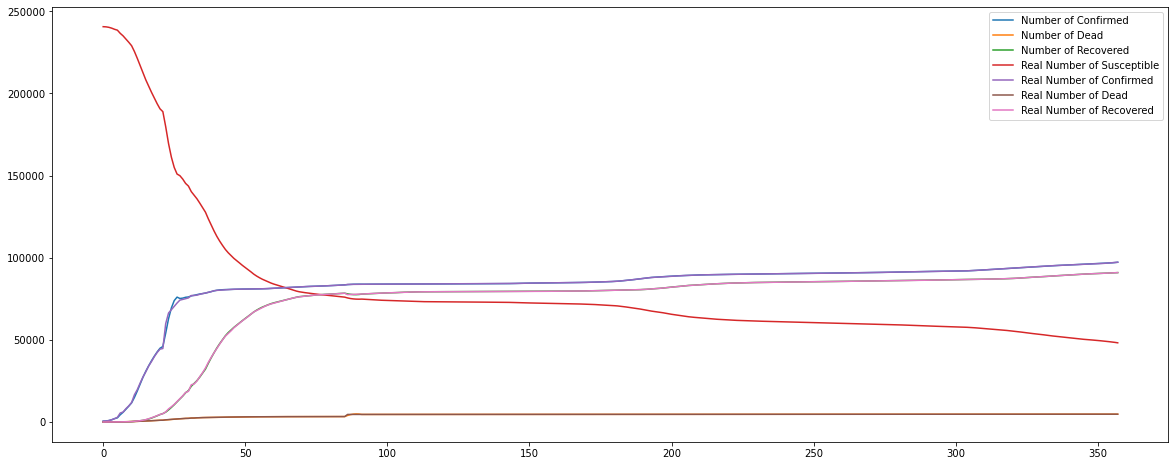

In [18]:
l = ['China']
main('time_series_19-covid-Confirmed-country.csv','time_series_19-covid-Recovered-country.csv','time_series_19-covid-Deaths-country.csv',l,j1 = True, j2 = True)

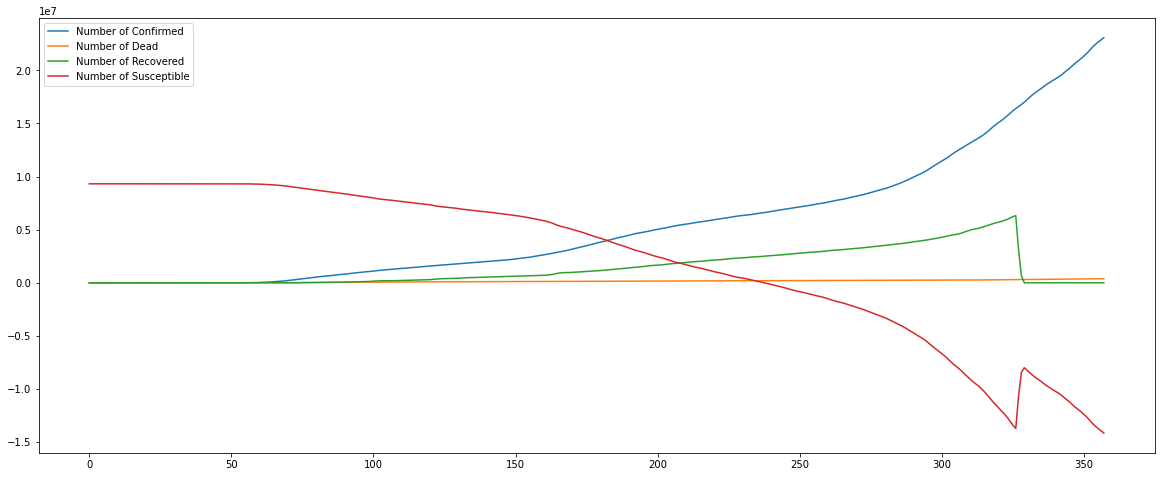

In [19]:
l = ['US']
main('time_series_19-covid-Confirmed-country.csv','time_series_19-covid-Recovered-country.csv','time_series_19-covid-Deaths-country.csv',l)

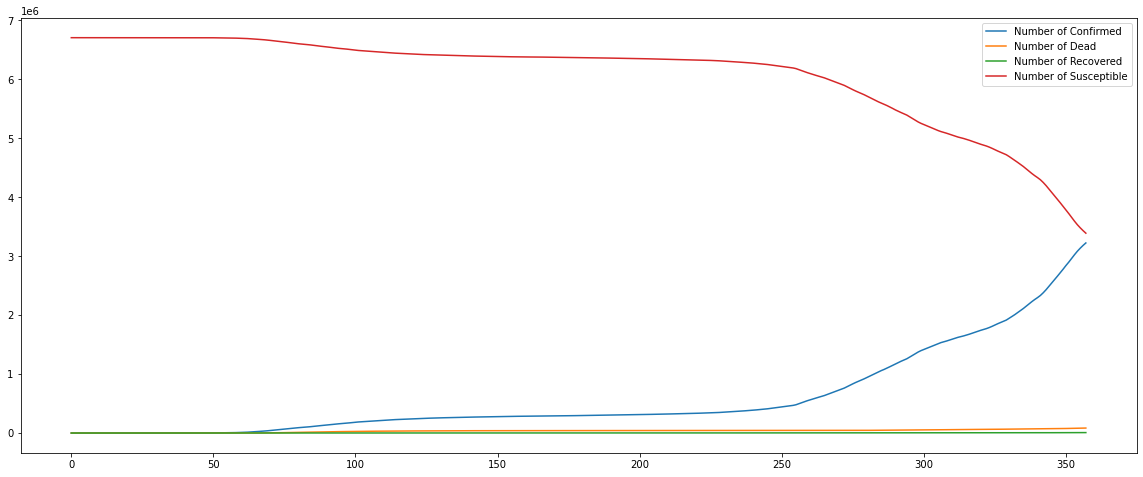

In [20]:
l = ['United Kingdom']
main('time_series_19-covid-Confirmed-country.csv','time_series_19-covid-Recovered-country.csv','time_series_19-covid-Deaths-country.csv',l)

Grey Forecasting Model


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class GrayForecast():
    def __init__(self, data, datacolumn=None):
 
        if isinstance(data, pd.core.frame.DataFrame):
            self.data=data
            try:
                self.data.columns = ['data']
            except:
                if not datacolumn:
                    raise Exception('Your dataframe has more than 1 column.')
                else:
                    self.data = pd.DataFrame(data[datacolumn])
                    self.data.columns=['data']
        elif isinstance(data, pd.core.series.Series):
            self.data = pd.DataFrame(data, columns=['data'])
        else:
            self.data = pd.DataFrame(data, columns=['data'])

        self.forecast_list = self.data.copy()

        if datacolumn:
            self.datacolumn = datacolumn
        else:
            self.datacolumn = None

        
    def level_check(self):
        n = len(self.data)
        lambda_k = np.zeros(n-1)
        for i in range(n-1):
            lambda_k[i] = self.data.ix[i]["data"]/self.data.ix[i+1]["data"]
            if lambda_k[i] < np.exp(-2/(n+1)) or lambda_k[i] > np.exp(2/(n+2)):
                flag = False
        else:
            flag = True

        self.lambda_k = lambda_k

        if not flag:
            print("Level check failed. Please add a constant")
            return False
        else:
            print("Level check successed!")
            return True
    
    def GM_11_build_model(self, forecast=5):
        if forecast > len(self.data):
            raise Exception('More data are required.')
        X_0 = np.array(self.forecast_list['data'].tail(forecast))
        X_1 = np.zeros(X_0.shape)
        for i in range(X_0.shape[0]):
            X_1[i] = np.sum(X_0[0:i+1])
        Z_1 = np.zeros(X_1.shape[0]-1)
        for i in range(1, X_1.shape[0]):
            Z_1[i-1] = -0.5*(X_1[i]+X_1[i-1])

        B = np.append(np.array(np.mat(Z_1).T), np.ones(Z_1.shape).reshape((Z_1.shape[0], 1)), axis=1)
        Yn = X_0[1:].reshape((X_0[1:].shape[0], 1))

        B = np.mat(B)
        Yn = np.mat(Yn)
        a_ = (B.T*B)**-1 * B.T * Yn

        a, b = np.array(a_.T)[0]

        X_ = np.zeros(X_0.shape[0])
        def f(k):
            return (X_0[0]-b/a)*(1-np.exp(a))*np.exp(-a*(k))

        self.forecast_list.loc[len(self.forecast_list)] = f(X_.shape[0])
    
    def forecast(self, time=5, forecast_data_len=5):
        for i in range(time):
            self.GM_11_build_model(forecast=forecast_data_len)
    
    def log(self):
        res = self.forecast_list.copy()
        if self.datacolumn:
            res.columns = [self.datacolumn]
        return res
    
    def reset(self):
        self.forecast_list = self.data.copy()
    
    def get_forecast_list(self):
        return self.forecast_list

    

In [22]:
def main(country, l, j1 = False, j2 = False):
    l_data = []
    judgment = True 
    if country == 'China':
        df_G = pd.read_csv('time_series_19-covid-China.csv')
    elif country == 'US':
        df_G = pd.read_csv('time_series_19-covid-US.csv')
    else:
        df_G = pd.read_csv('time_series_19-covid-United Kingdom.csv')
    for item in l:
        l_pred = []

        for i in range(5):
            data = df_G.loc[i,item]
            l_pred.append(data)
            
        for n in range(358-5):
            df = df_G.loc[[n,n+1,n+2,n+3,n+4,n+5]]
            Gf = GrayForecast(df,item)
            try:
                Gf.forecast(1)
                Gf.log()
                l1 = Gf.get_forecast_list()
                l_pred.append(l1.loc[n+5,'data'])
            except:
                judgment = False
                print('The data is ont good enough to finish the matrix inverse.')
                break
        
        if judgment:
            l_data.append(l_pred)
            plt.plot(l_x, l_pred)
            if j1:
                plt.plot(l_x, df_G[item])

    if judgment:    
        if j2:
            loss_c = ave_relative_loss(df_G[item],l_data[0])
            loss_d = ave_relative_loss(df_G[item],l_data[1])
            loss_r = ave_relative_loss(df_G[item],l_data[2])
            print(loss_c,loss_d,loss_r)

        if j1:
            plt.legend(['Predicted Confirmed','Predicted Deaths','Predicted Recovered', 'True Confirmed','True Deaths','True Recovered'])
        else:
            plt.legend(l)
        plt.show()
    


0.17651684601833975 17.010376601937644 2.0429843266769723e-05


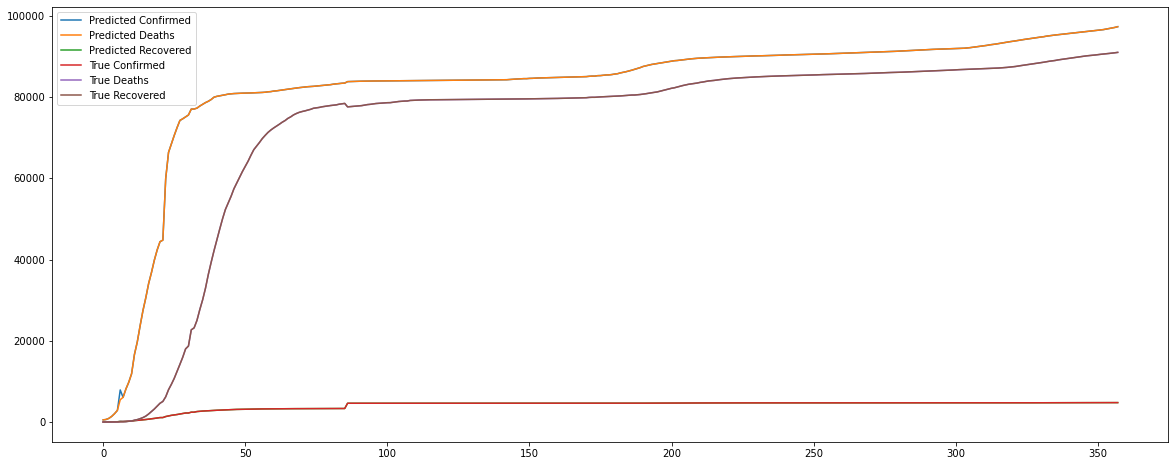

In [23]:
main('China', ['Confirmed','Deaths','Recovered'],j1 = True, j2 = True)